# Objectives:
- Build a classification model which will be able to tell how likely a given user session is to become a customer based on browsing behavior, referral source, device, and location  
    - This classifier can be used in realtime to predict which users aren't likely to convert  
    - Before they are anticipated to end their session, they can automatically be given a coupon or offered free shipping to increase their chances of buying 
- Evaluate model accuracy and misclassification rates 
- Project ROI from implementation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.precision = 3

from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

## Matrix preparation

In [8]:
# Import dataset and check dimensions

design_matrix = pd.read_csv('./design_matrix.csv', index_col=0)
design_matrix.shape

(62801, 172)

In [21]:
# Encode categorical variables 
dummies = pd.get_dummies(design_matrix.drop('made_purchase', axis=1), columns=['ip_state', 'source'])

# Scale x matrix
y = design_matrix.made_purchase
x = StandardScaler().fit_transform(dummies)

# Split into control, testing, and training sets
x, control_x, y, control_y = train_test_split(x, y, test_size=.1, random_state=5)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=.2, random_state=5)

# Oversample training data
xtrain, ytrain = SMOTE(random_state=0).fit_sample(xtrain, ytrain)

# Check class balance and verify dimensions
print "Training class proportions:", ytrain.mean()
print "Test class proportions:", round(ytest.mean(), 3)
print x.shape, control_x.shape, xtrain.shape, xtest.shape

Training class proportions: 0.5
Test class proportions: 0.048
(56520, 768) (6281, 768) (86042, 768) (11304, 768)


/usr/local/lib/python2.7/dist-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2017-08-29 23:28:18.089017. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [ ]:
# Set baseline for test set

baseline =  1 - ytest.mean()
print "Test set baseline accuracy: ", baseline

## Model selection
I will be testing 6 different classifier algorithms out of the box to choose which one to tune.  
I've created a "performance score" metric which shows a model's performance above baseline normalized on a 0 - 1.0 scale.

In [5]:
lr = LogisticRegression(random_state=5, n_jobs=-1)
lr.fit(xtrain, ytrain)
print "Performance score: ", (lr.score(xtest, ytest) - baseline) * (1 / (1 - baseline))

Performance score:  0.327137546468


In [19]:
lr = LogisticRegression(random_state=5, n_jobs=-1)
lr.fit(xtrain, ytrain)
lr.score(xtest, ytest)

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


0.88782731776362345

/usr/local/lib/python2.7/dist-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2017-08-29 23:25:31.344807. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [62]:
bnb = BernoulliNB()
bnb.fit(xtrain, ytrain)
print "Performance score: ", (bnb.score(xtest, ytest) - baseline) * (1 / (1 - baseline))

Performance score:  0.418215613383


In [63]:
sgd = SGDClassifier(random_state=5, n_jobs=-1)
sgd.fit(xtrain, ytrain)
print "Performance score: ", (sgd.score(xtest, ytest) - baseline) * (1 / (1 - baseline))

Performance score:  0.304832713755


In [64]:
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(xtrain, ytrain)
print "Performance score: ", (knn.score(xtest, ytest) - baseline) * (1 / (1 - baseline))

Performance score:  0.433085501859


In [65]:
dtc = DecisionTreeClassifier(random_state=5)
dtc.fit(xtrain, ytrain)
print "Performance score: ", (dtc.score(xtest, ytest) - baseline) * (1 / (1 - baseline))

Performance score:  0.661710037175


In [66]:
rfc = RandomForestClassifier(random_state=5, n_jobs=-1)
rfc.fit(xtrain, ytrain)
print "Performance score: ", (rfc.score(xtest, ytest) - baseline) * (1 / (1 - baseline))

Performance score:  0.671003717472


## Random Forest wins
Next, I'll tune to find the optimal hyperparameters. Keep in mind the baseline is 95.24% when evaluating the accuracy score.

In [6]:
# Use class weight for imbalanced data

rfc = RandomForestClassifier(n_estimators=30,
                             max_features=100,
                             max_depth=500, 
                             random_state=5, 
                             n_jobs=-1)
rfc.fit(xtrain, ytrain)

print "Performance score: ", (rfc.score(xtest, ytest) - baseline) * (1 / (1 - baseline))

Performance score:  0.700743494424


In [7]:
# To better understand the user behavior, let's examine the 10 highest weighted features by random forest

pd.DataFrame({'weight': rfc.feature_importances_, 'feature': dummies.columns}).sort_values('weight', ascending=False).head(18)

,feature,weight
759,source_shopify,0.346
0,KendrickLamar,0.053
1,TDEApparel,0.051
737,source_TDE,0.037
18,Account,0.031
3,Categories,0.030
2,Collections,0.028
4,NewArrivals,0.026
742,source_direct,0.025
39,CreateAccount,0.024


In [8]:
# Test the trained model for accuracy and misclassification

probas = pd.DataFrame({'true': ytest, 'pred': rfc.predict_proba(xtest)[:,1]})

tp = len(probas[(probas.true == 1) & (probas.pred > .5)])
tn = len(probas[(probas.true == 0) & (probas.pred <= .5)])
fp = len(probas[(probas.true == 0) & (probas.pred > .5)])
fn = len(probas[(probas.true == 1) & (probas.pred <= .5)]) 

print 'Accuracy score: %', float(tp + tn) / len(ytest) * 100
print 'True positives: ', tp, " True positive rate: ", float(tp) / len(ytest) * 100
print 'True negative: ', tn, " True negative rate: ", float(tn) / len(ytest) * 100
print 'False positives: ', fp, " False positive rate: ", float(fp) / len(ytest) * 100
print 'False negatives: ', fn, " False negative rate: ", float(fn) / len(ytest) * 100

Accuracy score: % 98.5757254069
True positives:  503  True positive rate:  4.44975230007
True negative:  10640  True negative rate:  94.1259731069
False positives:  126  False positive rate:  1.11464968153
False negatives:  35  False negative rate:  0.309624911536


## Examining misclassification
A false positive means our model predicted a potential buyer for someone who is never going to buy.  
A false negative means our model predicted a non-buyer for someone who is going to buy.  
  
Since the goal is maximizing profit, I only want to offer promotions to the users who are on the fence about buying.  
I want to avoid users who are on either end of the probability spectrum and focus on those who are close to a 50% chance of converting.  
  
This minimizes consumer surplus, retaining profit that would be lost by giving discounts to users who are willing to pay full price.  
It also retains the integrity of the promotional offer, since it wont be offered automatically to the 95% of users who never had intent to buy. 

In [9]:
# Let's see what the probabilities look like for the four classification categories
# This will help me choose appropriate thresholds for promotional offers

tp = probas[(probas.true == 1) & (probas.pred >= .5)].reset_index(drop=True)
tn = probas[(probas.true == 0) & (probas.pred < .5)].reset_index(drop=True)
fp = probas[(probas.true == 0) & (probas.pred >= .5)].reset_index(drop=True)
fn = probas[(probas.true == 1) & (probas.pred < .5)].reset_index(drop=True)

probas_table = pd.concat([tp.head(10), tn.head(10), fp.head(10), fn.head(10)], axis=1, ignore_index=True)
probas_table.columns = pd.MultiIndex.from_tuples([('true positives', 'prediction'), ('true positives', 'actual'), ('true negatives', 'prediction'), ('true negatives', 'actual'), 
                                                  ('false positives', 'prediction'), ('false positives', 'actual'), ('false negatives', 'prediction'), ('false negatives', 'actual')])
probas_table

true positives        true negatives        false positives         \
      prediction actual     prediction actual      prediction actual   
0          0.783      1            0.0      0           0.605      0   
1          0.869      1            0.0      0           0.605      0   
2          0.933      1            0.0      0           0.557      0   
3          0.996      1            0.0      0           0.783      0   
4          0.633      1            0.0      0           0.774      0   
5          0.567      1            0.0      0           0.633      0   
6          0.966      1            0.0      0           0.557      0   
7          1.000      1            0.0      0           0.774      0   
8          0.774      1            0.0      0           0.722      0   
9          0.984      1            0.0      0           0.758      0   

  false negatives         
       prediction actual  
0           0.429      1  
1           0.300      1  
2           0.000      1  
3           0.436      1  
4           0.367      1  
5           0.258      1  
6           0.067      1  
7           0.200      1  
8           0.133      1  
9           0.453      1

True positives are all mostly above the .6 threshold while true negatives are all bottomed out.  
False positives are falling within .8 and false negatives are all over the place.  
  
This is only a subset of 10 observations from each category. I'll display the summary statistics for each below to get a better idea of the entire spread. 

In [10]:
# Test a narrower threshold range

summary_stats = pd.concat([tp.pred.describe(), tn.pred.describe(), fp.pred.describe(), fn.pred.describe()], axis=1, ignore_index=True)
summary_stats.columns = ['true positives', 'true negatives', 'false positives', 'false negatives']
summary_stats

,true positives,true negatives,false positives,false negatives
count,505.000,10635.000,131.000,33.000
mean,0.846,0.004,0.697,0.309
std,0.156,0.032,0.149,0.133
min,0.500,0.000,0.500,0.000
25%,0.764,0.000,0.557,0.200
50%,0.906,0.000,0.709,0.333
75%,1.000,0.000,0.774,0.433
max,1.000,0.498,1.000,0.467


## Offering promotions to the right users
The mean for false positives and false negatives fall close to 0.7 and 0.3, respectively. I will set my thresholds to 0.2 and 0.8 to make sure I'm capturing all the uncertainty from the model.  

I also want to observe the prediction intervals at a 90% confidence to make sure I am excluding any users that my model is unsure about. This will discourage predictions being made too early for users who we haven't collected enough data on yet. 

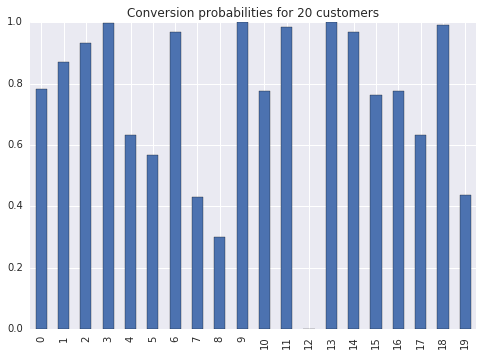

In [60]:
# Deconstruct Random Forest algorithm to estimate each tree individually and calculate percentile based prediction intervals

def pred_ints(model, X, y, percentile=90):
    estimations = pd.DataFrame({i: model.estimators_[i].predict_proba(X)[:,1] for i in range(len(model.estimators_))})
    estimations['lower'] = estimations.apply(lambda x: np.percentile(x, (100 - percentile) / 2. ), axis=1)
    estimations['upper'] = estimations.apply(lambda x: np.percentile(x, 100 - (100 - percentile) / 2. ), axis=1)
    estimations['proba'] = estimations.apply(lambda x: x[:30].mean(), axis=1)
    estimations['true'] = y.reset_index(drop=True)
    return estimations

est = pred_ints(rfc, xtest, ytest)

est[est.true == 1].proba[:20].reset_index(drop=True).plot(kind='bar', title='Conversion probabilities for 20 customers')

In [69]:
# Exclude users outside the prediction intervals and probability thresholds, return "on the fence users"

def otf_users(estimations, lower_thresh=.2, upper_thresh=.8):
    sub = estimations[(estimations.lower > 0.05) & (estimations.upper < 0.95) & (estimations.proba >= lower_thresh) & (estimations.proba <= upper_thresh)]
    return sub.index

promos = otf_users(est)

print "Customers offered promotions ", len(promos)
print "Customers not offered promotions: ", len(ytest) - len(promos)
print "Percentage of customers offered promotions: ", round(float(len(promos))/len(ytest) * 100, 2), '%'

Customers offered promotions  262
Customers not offered promotions:  11042
Percentage of customers offered promotions:  2.32 %


## Testing on unseen data

In [12]:
# Run same tests using control group

control_baseline = 1 - control_y.mean()
control_preds = pred_ints(rfc, control_x, control_y)
control_promos = otf_users(control_preds)

tp = len(control_preds[(control_preds.true == 1) & (control_preds.proba >= .5)])
tn = len(control_preds[(control_preds.true == 0) & (control_preds.proba < .5)])
fp = len(control_preds[(control_preds.true == 0) & (control_preds.proba >= .5)])
fn = len(control_preds[(control_preds.true == 1) & (control_preds.proba < .5)])

print "Performance score: ", (rfc.score(control_x, control_y) - control_baseline) * (1 / (1 - control_baseline))
print 'Accuracy score: %', float(tp + tn) / len(control_y) * 100
print '\nTrue positives: ', tp, " True positive rate: ", float(tp) / len(control_y) * 100
print 'True negative: ', tn, " True negative rate: ", float(tn) / len(control_y) * 100
print 'False positives: ', fp, " False positive rate: ", float(fp) / len(control_y) * 100
print 'False negatives: ', fn, " False negative rate: ", float(fn) / len(control_y) * 100
print "\nUsers offered promotions ", len(control_promos)
print "Users not offered promotions: ", len(control_y) - len(control_promos)
print "% of users offered promotions: %", float(len(control_promos))/len(control_y) * 100

Performance score:  0.632786885246
Accuracy score: % 98.2009234198

True positives:  279  True positive rate:  4.44196783952
True negative:  5889  True negative rate:  93.7589555803
False positives:  87  False positive rate:  1.38512975641
False negatives:  26  False negative rate:  0.413946823754

Users offered promotions  152
Users not offered promotions:  6129
% of users offered promotions: % 2.41999681579


## Whitespace & ROI analysis
Assuming that all of the customers offered promotions would convert, I'll calculate how many additional customers we could expect to bring in using this method.

#### `Section deleted to preserve confidential financial information`

The maximum ROI potential is **[hidden]**, or a 16% revenue increase per year, assuming that all users who are shown the promo make a purchase.  

In reality, we can't expect a 100% success rate, so I've plotted the potential ROI against promotion success rate. My conservative projection will assume a 50% success rate.

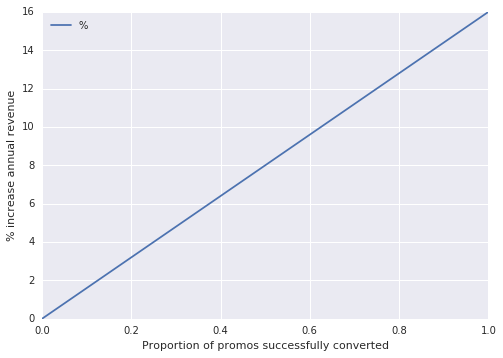

In [3]:
pd.DataFrame([0, 16], columns=['%']).plot(kind='line')
plt.xlabel('Proportion of promos successfully converted')
plt.ylabel('% increase annual revenue')

## 8% Annual Revenue Increase
Integral Studio can increase total revenue for Top Dawg Entertainment by approximately **8%** per year through implementation of this classifier algorithm, which makes a significant impact at a multi-million dollar company. This is assuming a 50% conversion rate from flash sales and does not factor in merchandise costs. Financial analysis and A/B testing should be performed after model implementation to pinpoint a more accurate success rate and ROI projection. 